In [36]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm

## Define transform and wrapper

In [37]:
# add all the augmentations you want to apply to the dataset
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.4649, 0.4851, 0.4108], std=[0.2307, 0.2293, 0.2464]),
])

normalize_transform = transforms.Compose([
    transforms.Normalize(mean=[0.4649, 0.4851, 0.4108], std=[0.2307, 0.2293, 0.2464]),
])

# apply other transformations to the dataset
class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Load dataset and apply transform

In [38]:
train_dataset = torch.load('dataset/train_dataset.pt')
val_dataset = torch.load('dataset/val_dataset.pt')
test_dataset = torch.load('dataset/test_dataset.pt')

# create dataloader
train_dataset = CustomDatasetWrapper(train_dataset, transform=augmentation_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDatasetWrapper(val_dataset, transform=normalize_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDatasetWrapper(test_dataset, transform=normalize_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# check dataset size
print('train dataset size:', len(train_dataset))
print('val dataset size:', len(val_dataset))
print('test dataset size:', len(test_dataset))

for x, y in train_loader:
    print(x.shape, y.shape)
    break

train dataset size: 3150
val dataset size: 675
test dataset size: 675
torch.Size([32, 3, 256, 256]) torch.Size([32])


/var/folders/c9/3dhl203d2k3g_d2pnb4cvpvr0000gn/T/ipykernel_28460/1891774407.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('dataset/train_dat

## Show some samples in train dataset

{0: 'red-billed-blue-magpie', 1: 'taiwan-blue-magpie', 2: 'yellow-billed-blue-magpie'}


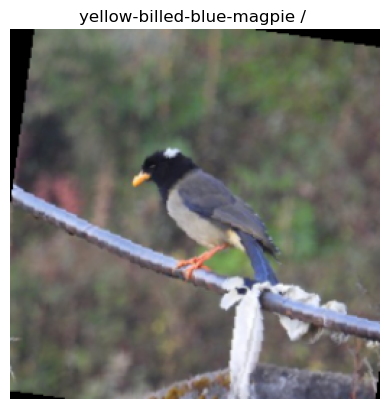

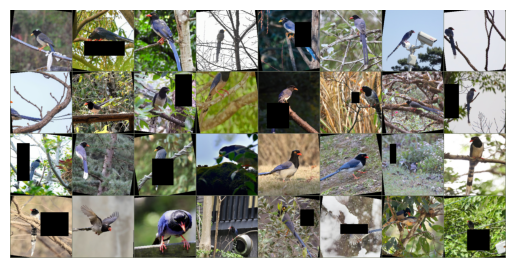

In [41]:
# labels map
# label_map = {v: k for k, v in train_dataset.class_to_idx.items()}
label_map = {0: 'red-billed-blue-magpie', 1: 'taiwan-blue-magpie', 2: 'yellow-billed-blue-magpie'}
print(label_map)

# define mean and std of the dataset(already calculated)
mean = [0.4659, 0.4855, 0.4103]
std = [0.2317, 0.2310, 0.2473]

# denormalize transform
denormalize_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# show images
def show_singel_image(image, label, pred=None):
    image = denormalize_transform(image)
    npimg = image.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.axis('off')
    plt.title(label_map[label] + ' / ' + (label_map[pred] if pred is not None else ''))
    plt.show()

def show_multiple_images(images):
    images = denormalize_transform(images)
    images = torchvision.utils.make_grid(images, nrow=8)
    npimg = images.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()


for img, label in train_loader:
    show_singel_image(img[0], label[0].item())
    show_multiple_images(torchvision.utils.make_grid(img, nrow=8))
    break

## Check if GPU is available

In [42]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('device:', device)

device: mps


## Define custom CNN model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # conv 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        # 256 x 256 -> 128 x 128
        
        # conv 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        # 128 x 128 -> 64 x 64
        
        # conv 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        # 64 x 64 -> 32 x 32

        # conv 4
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        # 32 x 32 -> 16 x 16

        # conv 5
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, 2)
        # 16 x 16 -> 8 x 8
        
        # fully connected layers
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 120)
        self.fc4 = nn.Linear(120, 3)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.pool5(self.relu5(self.conv5(x)))
        x = x.view(-1, 512 * 8 * 8)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.dropout(self.relu4(self.fc2(x)))
        x = self.dropout(self.relu4(self.fc3(x)))
        x = self.fc4(x)

        return x

model = SimpleCNN()
model.to(device)

# summary(SimpleCNN(), input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 3]                   --
├─Conv2d: 1-1                            [32, 32, 256, 256]        896
├─ReLU: 1-2                              [32, 32, 256, 256]        --
├─MaxPool2d: 1-3                         [32, 32, 128, 128]        --
├─Conv2d: 1-4                            [32, 64, 128, 128]        18,496
├─ReLU: 1-5                              [32, 64, 128, 128]        --
├─MaxPool2d: 1-6                         [32, 64, 64, 64]          --
├─Conv2d: 1-7                            [32, 128, 64, 64]         73,856
├─ReLU: 1-8                              [32, 128, 64, 64]         --
├─MaxPool2d: 1-9                         [32, 128, 32, 32]         --
├─Conv2d: 1-10                           [32, 256, 32, 32]         295,168
├─ReLU: 1-11                             [32, 256, 32, 32]         --
├─MaxPool2d: 1-12                        [32, 256, 16, 16]         --
├

## Or use pre-trained model

In [52]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# layers = list(model.children())[:-1]
# summary(model, input_size=(32, 3, 256, 256))
# layers = list(model.children())[:-1]


num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)
# summary(model, input_size=(32, 3, 256, 256))

## Define optimizer and loss function

In [53]:
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

## Define Training loop

In [54]:
# training loop
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_loss = []
    val_loss = []
    val_acc = []

    if not os.path.exists('ckpts'):
        os.makedirs('ckpts')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'epoch: {epoch + 1}, train loss: {train_loss[-1]}')
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                running_loss += loss.item()
                _, predicted = torch.max(y_hat, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()


        if len(val_acc) == 0 or correct / total > max(val_acc):
            torch.save(model.state_dict(), 'ckpts/simpleCNN.pth')
        
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)
        print(f'epoch: {epoch + 1}, val loss: {val_loss[-1]}, val acc: {val_acc[-1]}')

    return train_loss, val_loss, val_acc

## Start training

In [55]:
# train model
train_loss, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, criterion, epochs=20)

100%|██████████| 99/99 [02:01<00:00,  1.23s/it]


epoch: 1, train loss: 0.6398240376000452


100%|██████████| 22/22 [00:07<00:00,  2.94it/s]


epoch: 1, val loss: 0.6028453233567151, val acc: 0.7614814814814815


100%|██████████| 99/99 [01:54<00:00,  1.16s/it]


epoch: 2, train loss: 0.4587893643312984


100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


epoch: 2, val loss: 0.3549851707436822, val acc: 0.8488888888888889


100%|██████████| 99/99 [01:56<00:00,  1.17s/it]


epoch: 3, train loss: 0.4083457668923368


100%|██████████| 22/22 [00:07<00:00,  3.01it/s]


epoch: 3, val loss: 0.4684807813980363, val acc: 0.8148148148148148


100%|██████████| 99/99 [01:54<00:00,  1.16s/it]


epoch: 4, train loss: 0.3904357573600731


100%|██████████| 22/22 [00:07<00:00,  2.98it/s]


epoch: 4, val loss: 0.3333962805230509, val acc: 0.8577777777777778


100%|██████████| 99/99 [01:55<00:00,  1.16s/it]


epoch: 5, train loss: 0.36812023773337854


100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


epoch: 5, val loss: 0.317632296545939, val acc: 0.8725925925925926


100%|██████████| 99/99 [01:57<00:00,  1.18s/it]


epoch: 6, train loss: 0.32180067926946315


100%|██████████| 22/22 [00:07<00:00,  3.03it/s]


epoch: 6, val loss: 0.41386340626261453, val acc: 0.8533333333333334


100%|██████████| 99/99 [01:54<00:00,  1.15s/it]


epoch: 7, train loss: 0.3327952879245835


100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


epoch: 7, val loss: 0.2986348865405572, val acc: 0.8814814814814815


100%|██████████| 99/99 [01:55<00:00,  1.16s/it]


epoch: 8, train loss: 0.3096812262077524


100%|██████████| 22/22 [00:07<00:00,  3.09it/s]


epoch: 8, val loss: 0.31258675625378435, val acc: 0.8814814814814815


100%|██████████| 99/99 [01:54<00:00,  1.16s/it]


epoch: 9, train loss: 0.2764574929018213


100%|██████████| 22/22 [00:07<00:00,  2.99it/s]


epoch: 9, val loss: 0.46058622815392236, val acc: 0.8251851851851851


100%|██████████| 99/99 [01:53<00:00,  1.14s/it]


epoch: 10, train loss: 0.31394092979455235


100%|██████████| 22/22 [00:07<00:00,  2.96it/s]


epoch: 10, val loss: 0.290501362898133, val acc: 0.8888888888888888


100%|██████████| 99/99 [01:56<00:00,  1.18s/it]


epoch: 11, train loss: 0.2582074802632284


100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


epoch: 11, val loss: 0.2924761404177513, val acc: 0.88


100%|██████████| 99/99 [01:53<00:00,  1.15s/it]


epoch: 12, train loss: 0.25777618775163036


100%|██████████| 22/22 [00:07<00:00,  3.03it/s]


epoch: 12, val loss: 0.43950264113531873, val acc: 0.8814814814814815


100%|██████████| 99/99 [02:00<00:00,  1.22s/it]


epoch: 13, train loss: 0.24572100960696586


100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


epoch: 13, val loss: 0.3211879542557819, val acc: 0.8948148148148148


100%|██████████| 99/99 [01:59<00:00,  1.20s/it]


epoch: 14, train loss: 0.23236352890127837


100%|██████████| 22/22 [00:07<00:00,  3.02it/s]


epoch: 14, val loss: 0.2486924718726765, val acc: 0.914074074074074


100%|██████████| 99/99 [01:55<00:00,  1.17s/it]


epoch: 15, train loss: 0.237181681349422


100%|██████████| 22/22 [00:07<00:00,  3.00it/s]


epoch: 15, val loss: 0.323077031834559, val acc: 0.8859259259259259


100%|██████████| 99/99 [01:59<00:00,  1.21s/it]


epoch: 16, train loss: 0.20741526688439677


100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


epoch: 16, val loss: 0.3349875518205491, val acc: 0.9051851851851852


100%|██████████| 99/99 [01:57<00:00,  1.19s/it]


epoch: 17, train loss: 0.2146227155821492


100%|██████████| 22/22 [00:07<00:00,  2.93it/s]


epoch: 17, val loss: 0.24128843928602609, val acc: 0.9066666666666666


100%|██████████| 99/99 [02:05<00:00,  1.27s/it]


epoch: 18, train loss: 0.22103025184737313


100%|██████████| 22/22 [00:07<00:00,  2.99it/s]


epoch: 18, val loss: 0.34842133877629583, val acc: 0.8903703703703704


100%|██████████| 99/99 [01:57<00:00,  1.18s/it]


epoch: 19, train loss: 0.22479247064753013


100%|██████████| 22/22 [00:07<00:00,  2.99it/s]


epoch: 19, val loss: 0.44064424661072815, val acc: 0.8666666666666667


100%|██████████| 99/99 [01:57<00:00,  1.19s/it]


epoch: 20, train loss: 0.20546318489042195


100%|██████████| 22/22 [00:07<00:00,  2.98it/s]

epoch: 20, val loss: 0.20854662532325496, val acc: 0.9125925925925926


## Plot train / val graph

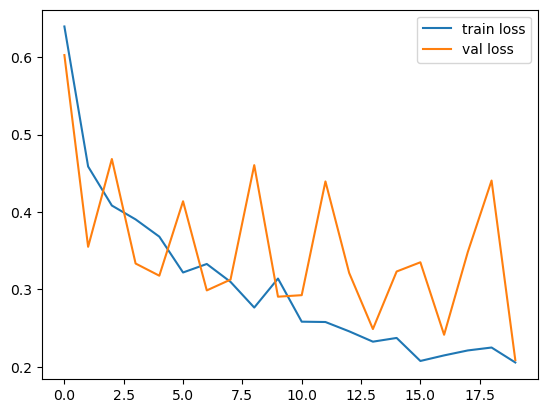

In [56]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

## Testting

tensor([[-0.7972, -8.5358,  4.2510]], device='mps:0',
       grad_fn=<LinearBackward0>)


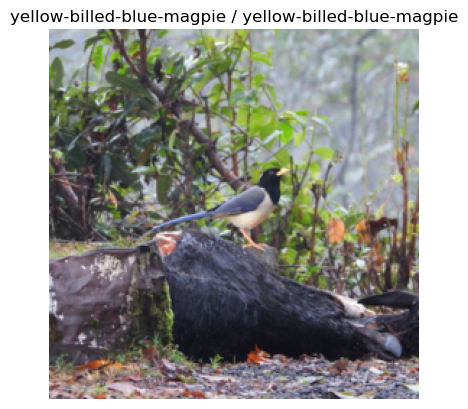

In [68]:
# test model
idx = random.randint(0, len(test_dataset))
x, y = test_dataset[idx]
x = x.unsqueeze(0).to(device)
y_hat = model(x)
print(y_hat)
_, predicted = torch.max(y_hat, 1)
show_singel_image(x[0].cpu(), y, predicted.item())